## 2x2 overlays: Cellpose on addhopin subset

Load four images from `data/addhopin blood cells/subset`, run default Cellpose, and show overlays rendered with tnia helper.

In [6]:
import os
from pathlib import Path
from skimage import io, color
import numpy as np
import matplotlib.pyplot as plt
from tnia.plotting.plt_helper import mask_overlay, mask_outline_overlay, ensure_three_channels

# Try to import cellpose; fall back gracefully if unavailable
try:
    from cellpose import models
    HAS_CELLPOSE = True
except Exception as e:
    print(f"Cellpose not available: {e}")
    HAS_CELLPOSE = False

In [7]:
# Data directory (relative to this notebook)
data_dir = Path("../data/addhopin blood cells/subset")
# Pick the first 4 .jpg files
image_paths = sorted([p for p in data_dir.glob("*.jpg")])[:4]

print("Selected images:")
for i, p in enumerate(image_paths):
    print(f"[{i}] {p}")

if len(image_paths) < 4:
    print("Warning: fewer than 4 images found in subset.")

Selected images:
[0] ../data/addhopin blood cells/subset/BloodImage_00134_jpg.rf.0d9da503b62e0034a2819a39cce7e7d9.jpg
[1] ../data/addhopin blood cells/subset/BloodImage_00154_jpg.rf.e5b45569e9cbede1ed36f82f14566c29.jpg
[2] ../data/addhopin blood cells/subset/BloodImage_00160_jpg.rf.894e8c8c7179ec9958a4d6c7b6b45616.jpg
[3] ../data/addhopin blood cells/subset/BloodImage_00190_jpg.rf.3e0bf272a5f8ea902775e4cbc56c538c.jpg


In [8]:
# Cellpose default segmentation helper (aligned with 11_cellpose_diameter style)
import torch
from cellpose import models

def run_cellpose_default(img, diameter=None, model_type="cyto2"):
    """Run Cellpose on the input image and return instance masks.
    - Uses GPU if available.
    - Follows the pattern from 11_cellpose_diameter: call model.eval(img, diameter=...).
    - Does not pre-convert to grayscale; Cellpose handles channels internally.
    """
    use_gpu = torch.cuda.is_available()
    # Instantiate model; prefer specific model_type when provided
    try:
        model = models.Cellpose(gpu=use_gpu, model_type=model_type)
    except Exception:
        # Fallback to generic model if specific type not available
        model = models.CellposeModel(gpu=use_gpu)
    
    # Evaluate with diameter=None (auto) unless a value is provided
    result = model.eval(img, diameter=diameter)
    # model.eval may return masks directly or a tuple; normalize to masks
    if isinstance(result, tuple):
        masks = result[0]
    else:
        masks = result
    return masks

In [9]:
# Run segmentation and create overlays
overlays = []
images = []
masks_list = []

for p in image_paths:
    img = io.imread(str(p))
    img = ensure_three_channels(img)
    mask = run_cellpose_default(img)
    overlay = mask_overlay(img, mask)
    images.append(img)
    masks_list.append(mask)
    overlays.append(overlay)

print("Generated overlays for", len(overlays), "images.")

Generated overlays for 4 images.


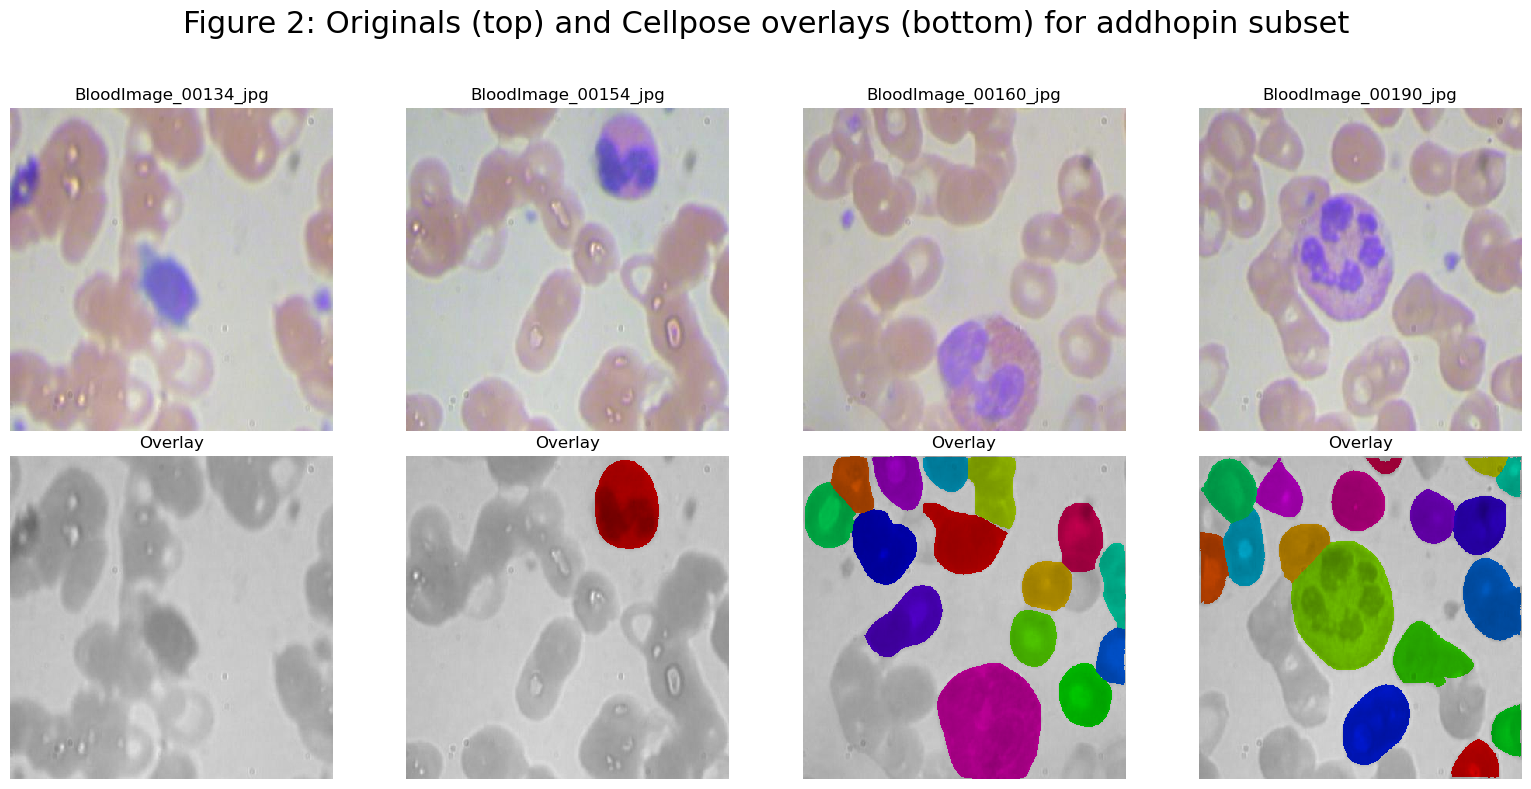

In [10]:
# Display originals (top row) and overlays (bottom row) in a 2 x 4 grid
import os

def short_name(p):
    base = os.path.basename(str(p))
    idx = base.lower().find('jpg')
    return base[:idx+3] if idx != -1 else base

n = min(4, len(images), len(overlays))
fig, axes = plt.subplots(2, n, figsize=(4*n, 8))

for col in range(n):
    # Top: original RGB image
    axes[0, col].imshow(images[col])
    axes[0, col].set_title(short_name(image_paths[col]))
    axes[0, col].axis('off')
    
    # Bottom: overlays (mask overlays on originals)
    axes[1, col].imshow(overlays[col])
    axes[1, col].set_title('Overlay')
    axes[1, col].axis('off')

# Big title at the top of the figure
plt.suptitle('Figure 2: Originals (top) and Cellpose overlays (bottom) for addhopin subset', fontsize=22, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Figure 2 caption
Top row shows the original RGB images from the addhopin blood cells subset; bottom row shows overlays of Cellpose instance segmentation masks on the originals (model_type = 'cyto2', diameter = None). Distinct colors indicate individual cell instances. Images were processed with default parameters and displayed without additional preprocessing.

In [12]:
# Build outline overlays for the selected images
outline_overlays = []
for i, (img, mask) in enumerate(zip(images, masks_list)):
    outline = mask_outline_overlay(img, mask, color=(0, 255, 255), thickness=2)
    outline_overlays.append(outline)
print("Generated", len(outline_overlays), "outline overlays.")

Generated 4 outline overlays.


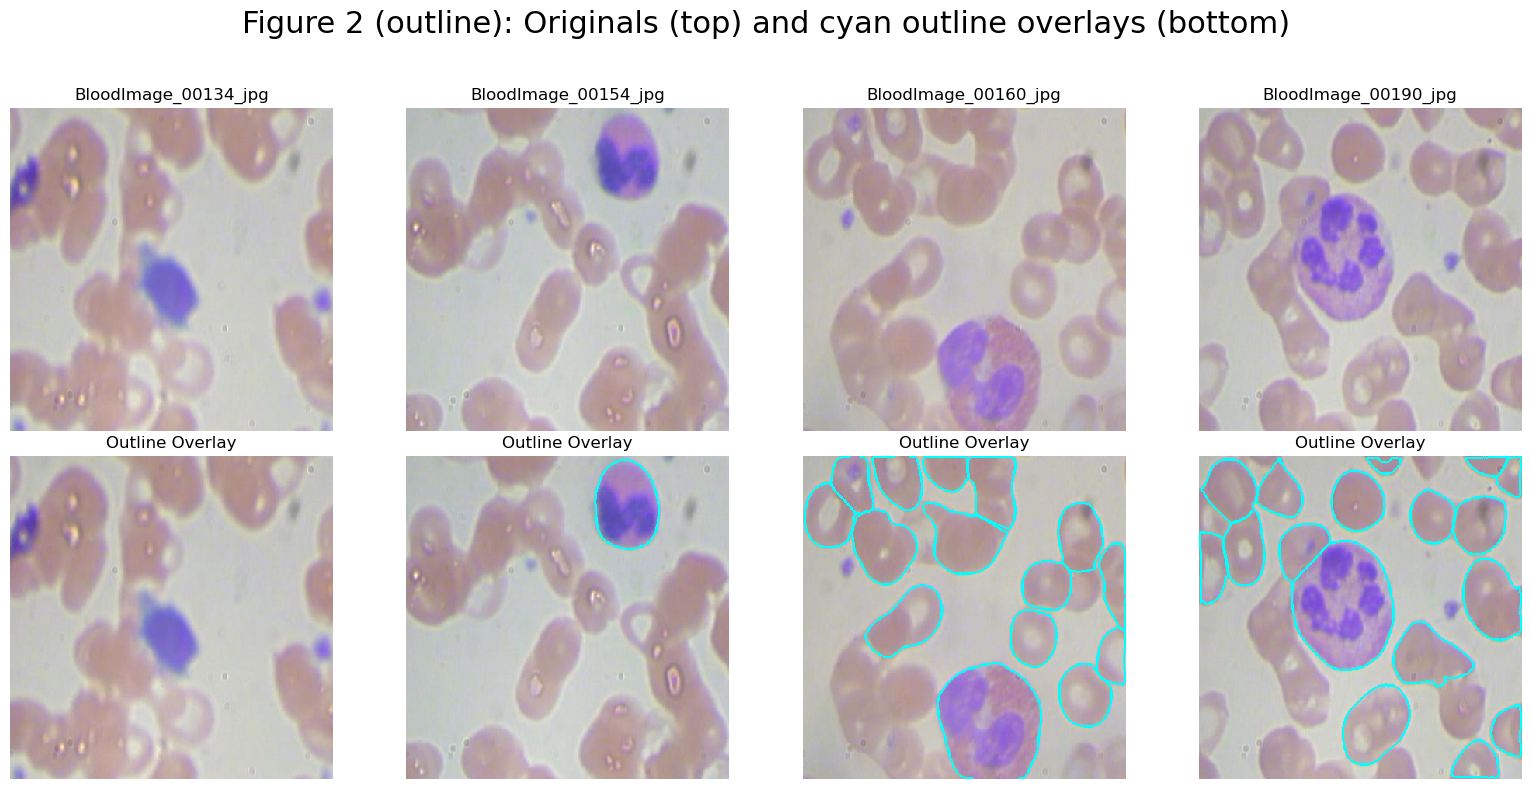

In [13]:
# Display originals (top row) and outline overlays (bottom row) in a 2 x 4 grid
import os

def short_name(p):
    base = os.path.basename(str(p))
    idx = base.lower().find('jpg')
    return base[:idx+3] if idx != -1 else base

n = min(4, len(images), len(outline_overlays))
fig, axes = plt.subplots(2, n, figsize=(4*n, 8))

for col in range(n):
    # Top: original RGB image
    axes[0, col].imshow(images[col])
    axes[0, col].set_title(short_name(image_paths[col]))
    axes[0, col].axis('off')
    
    # Bottom: outline overlays
    axes[1, col].imshow(outline_overlays[col])
    axes[1, col].set_title('Outline Overlay')
    axes[1, col].axis('off')

plt.suptitle('Figure 2 (outline): Originals (top) and cyan outline overlays (bottom)', fontsize=22, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()